<a href="https://colab.research.google.com/github/DarwinFer/Burgers1DPINNvsFEME3/blob/main/E3Burgers1DPINNvsFEMconIniDiferente.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Ejemplo 3:   PINNs vs FEM

A continuacion presentamos un ejemplo  que ilustra la diferencia entre los enfoques PINNs  y FEM, en el ejemplo particular de un problema directo asociado a la la Ecuación de Burges viscosa en una dimensión.

La formulación matemática es la siguiente:

$$
 \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2},
$$
Para  $(x,t) \in (0,1)\times(0,1]$. Sujera a la condición inicial,

 $$
 u(x,0) = u_{0}(x), \qquad  x \in [-1,1],
 $$

 y a condiciones de forntera tipo Dirichlet,
$$
u(t,0) = u(t,1) = 0, \qquad  t \in [0,T]
$$


Aquí, $\nu  > 0$ representa la viscosidad cinemática del medio  y la condición  $u(x,0) = u_{0} $ define un perfil el instante inicial.

##Enfoque Redes Neuronales Informadas po la Física  (PINNs)

> Deseamos resolver el problema directo definido anteriormente mediante una red neuronal informada por la fisica, para ello incorporamos la estructura física del problema definiendo la siguiente función de péridida total
$$ \mathcal{L}(\theta) =  \lambda_{ic}   \mathcal{L}_{\text{ic}} + \lambda_{bc} \mathcal{L}_{\text{bc}} + \lambda_{r} \mathcal{L}_{r}  $$

donde
$\mathcal{L}_{\text{r}} = \frac{1}{N_r} \sum_{i=1}^{N_r} \left| \underbrace{\frac{\partial \hat{u}}{\partial t} + \hat{u} \frac{\partial \hat{u}}{\partial x} - \nu \frac{\partial^2 \hat{u}}{\partial x^2}}_{\mathcal{R}_{\theta}}   \right|^2,$ $\mathcal{L}_{\text{IC}} = \frac{1}{N_0} \sum_{i=1}^{N_0} \left| \hat{u}(x_i,0) - u_0(x_i) \right|^2, $
  y $ \mathcal{L}_{\text{BC}} = \frac{1}{N_b} \sum_{i=1}^{N_b} \left( \left| \hat{u}(0,t_i) \right|^2 + \left| \hat{u}(1,t_i)  \right|^2 \right).$ Representan la perdida residual de la EDP, la perdida en la condición inicial y en la frontera respectivamente.   Elegimos una condición inicial $u_{0}(x)$ la cual NO se conoce apriori que proviene de una solución exacta.
  $$
u_{0} (x) =-\sin(\pi x)
  $$
Los parametros ultilizamos para este experimento son  $\nu= \frac{1}{100}\pi$.

Epoch 0, Loss: 5.21e-01
Epoch 500, Loss: 1.12e-01
Epoch 1000, Loss: 9.61e-02
Epoch 1500, Loss: 8.92e-02
Epoch 2000, Loss: 8.55e-02
Epoch 2500, Loss: 8.22e-02
Epoch 3000, Loss: 7.86e-02
Epoch 3500, Loss: 7.40e-02
Epoch 4000, Loss: 5.96e-02
Epoch 4500, Loss: 4.67e-02
Epoch 5000, Loss: 4.40e-02
Epoch 5500, Loss: 4.31e-02
Epoch 6000, Loss: 4.25e-02
Epoch 6500, Loss: 4.17e-02
Epoch 7000, Loss: 4.06e-02
Epoch 7500, Loss: 3.95e-02
Epoch 8000, Loss: 3.85e-02
Epoch 8500, Loss: 3.73e-02
Epoch 9000, Loss: 3.59e-02
Epoch 9500, Loss: 3.35e-02


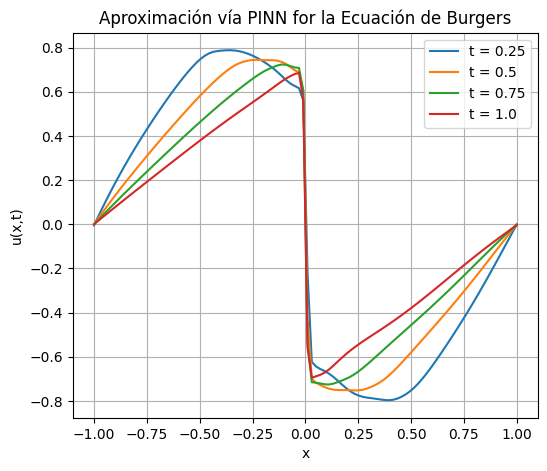

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Red neuronal para resolver la Ecuación de Burgers mediante PINN
class BurgersPINN(nn.Module):
    def __init__(self):
        super(BurgersPINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 50),  # Entradas: x y t
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1) #una salia u(x,t)
        )

    def forward(self, x, t):
        inputs = torch.cat((x, t), dim=1)  # Concatena x y t a lo largo de la dimensión de características
        return self.net(inputs)

# Instancia del modelo
model = BurgersPINN()

# Generación de los datos de entrenamiento
# Dominio: x en [-1, 1] y t en [0, 1]
n_interior = 10000  # Puntos interiores para imponer la PDE
# Puntos interiores aleatorios (x,t) para la PDE
x_interior = torch.rand(n_interior, 1) * 2 - 1  # mapea de [0,1] a [-1,1]
t_interior = torch.rand(n_interior, 1)          # t en [0,1]
x_interior.requires_grad = True
t_interior.requires_grad = True

# Condición inicial: u(x,0) = -sin(pi*x)
n_initial = 200
x_initial = torch.linspace(-1, 1, n_initial).reshape(-1, 1)
t_initial = torch.zeros_like(x_initial)
u_initial = -torch.sin(np.pi * x_initial)

# Condiciones de frontera: u(-1,t) = 0 y u(1,t) = 0 para t en [0,1]
n_boundary = 200
t_boundary = torch.linspace(0, 1, n_boundary).reshape(-1, 1)
x_boundary_left = -torch.ones_like(t_boundary)
x_boundary_right = torch.ones_like(t_boundary)
u_boundary_left = torch.zeros_like(t_boundary)
u_boundary_right = torch.zeros_like(t_boundary)

# Parámetro de viscosidad
nu = 0.01 / np.pi


# Función de pérdida que combina la imposición de la PDE, condición inicial y de frontera
def loss_function(model, x_interior, t_interior, x_initial, t_initial, u_initial,
                  x_boundary_left, x_boundary_right, t_boundary, u_boundary_left, u_boundary_right):
    # Parte de la PDE: u_t + u * u_x - nu * u_xx = 0
    u_interior = model(x_interior, t_interior)
    # Derivada respecto al tiempo t
    u_t = torch.autograd.grad(u_interior, t_interior,
                              grad_outputs=torch.ones_like(u_interior),
                              create_graph=True)[0]
    # Derivada respecto al espacio x
    u_x = torch.autograd.grad(u_interior, x_interior,
                              grad_outputs=torch.ones_like(u_interior),
                              create_graph=True)[0]
    # Segunda derivada respecto a x
    u_xx = torch.autograd.grad(u_x, x_interior,
                               grad_outputs=torch.ones_like(u_x),
                               create_graph=True)[0]

    # Residuo de la ecuación de Burgers
    f = u_t + u_interior * u_x - nu * u_xx
    pde_loss = torch.mean(f**2)

    # Pérdida para la condición inicial: u(x,0) = -sin(pi*x)
    u_initial_pred = model(x_initial, t_initial)
    initial_loss = torch.mean((u_initial_pred - u_initial)**2)

    # Pérdida para las condiciones de frontera: u(-1,t)=0 y u(1,t)=0
    u_boundary_left_pred = model(x_boundary_left, t_boundary)
    u_boundary_right_pred = model(x_boundary_right, t_boundary)
    boundary_loss = torch.mean((u_boundary_left_pred - u_boundary_left)**2) + \
                    torch.mean((u_boundary_right_pred - u_boundary_right)**2)

    return pde_loss + initial_loss + boundary_loss

# Configuración del optimizador
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Bucle de entrenamiento
epochs = 10000
# Listas para almacenar el historial de pérdidas
loss_history = []
epoch_history = []
for epoch in range(epochs):
    optimizer.zero_grad()
    loss = loss_function(model, x_interior, t_interior, x_initial, t_initial, u_initial,
                         x_boundary_left, x_boundary_right, t_boundary, u_boundary_left, u_boundary_right)
    loss.backward()
    optimizer.step()
    # Guardar historial de pérdidas
    loss_history.append(loss.item())
    epoch_history.append(epoch)

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.2e}")

# Evaluación del modelo
# Vamos a graficar la solución aproximada u(x,t) para diferentes instantes de tiempo: t = 0.25, 0.5, 0.75 y 1.0.
n_plot = 100
x_plot = torch.linspace(-1, 1, n_plot).reshape(-1, 1)
t_vals = [0.25, 0.5, 0.75, 1.0]

plt.figure(figsize=(6,5))
for t_val in t_vals:
    t_plot = torch.full((n_plot, 1), t_val)
    u_pred = model(x_plot, t_plot).detach().numpy()
    plt.plot(x_plot.numpy(), u_pred, label=f't = {t_val}')

plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title('Aproximación vía PINN for la Ecuación de Burgers')
plt.legend()
plt.grid()
plt.show()


>Perdida PINN.


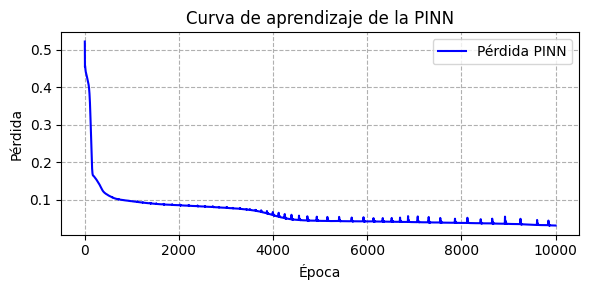

In [ ]:
# Configurar la gráfica
plt.figure(figsize=(6, 3))
plt.plot(epoch_history, loss_history, 'b-', linewidth=1.5, label='Pérdida PINN')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Curva de aprendizaje de la PINN')
#plt.yscale('log')  # Escala logarítmica para mejor visualización
plt.grid(True, which="both", ls="--")
plt.legend()
plt.tight_layout()
plt.savefig("PerdidaPINNEX3.pdf", format="pdf")
plt.show()

>Gráfica 2D

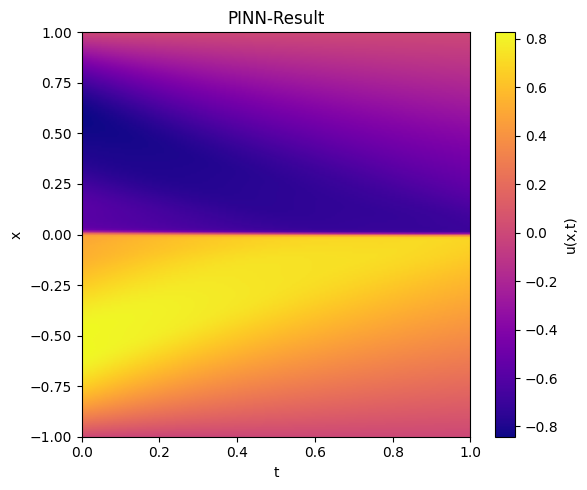

In [ ]:
# ------------------------------------------------------------
# Gráfico 2-D estilo “(b) PINN-Result”
# ------------------------------------------------------------
# Densidad de la malla
n_x, n_t = 200, 200           # puedes aumentarlos para más resolución

# Mallado (x,t)  →  X.shape = (n_x, n_t),  T.shape = (n_x, n_t)
x_grid = torch.linspace(-1, 1, n_x).reshape(-1, 1)
t_grid = torch.linspace(0, 1, n_t).reshape(1,  -1)
X, T   = torch.meshgrid(x_grid.squeeze(), t_grid.squeeze(), indexing='ij')

# Aplanamos y concatenamos para el forward del modelo
XT = torch.cat((X.reshape(-1, 1), T.reshape(-1, 1)), dim=1)
with torch.no_grad():
    U = model(XT[:, 0:1], XT[:, 1:2]).cpu().numpy().reshape(n_x, n_t)

# Plot
plt.figure(figsize=(6, 5))
im = plt.imshow(
    U,
    extent=(0, 1, -1, 1),      # (t_min, t_max, x_min, x_max)
    origin='lower',            # -1 aparece abajo, 1 arriba
    aspect='auto',
    cmap='plasma'              # paleta similar a la del ejemplo
)
plt.xlabel('t')
plt.ylabel('x')
plt.title('PINN-Result')
plt.colorbar(im, label='u(x,t)')
plt.tight_layout()
plt.savefig("ResultadoPINNEX3.pdf", format="pdf")
plt.show()



> Gráfico 3D

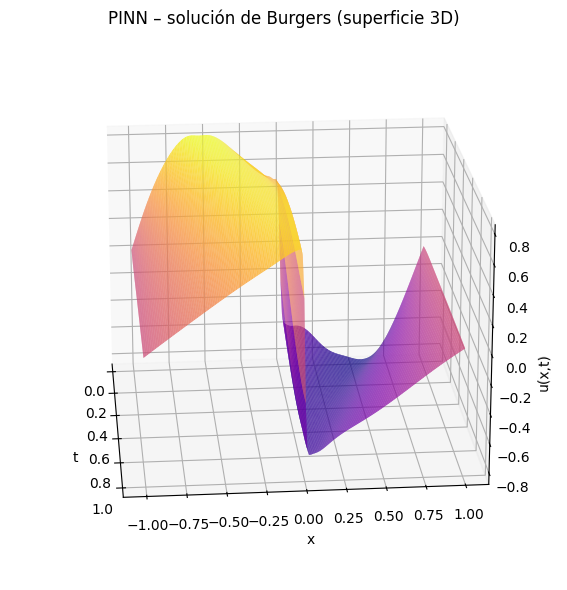

In [ ]:
# ------------------------------------------------------------
# Superficie 3-D de u(x,t)
# ------------------------------------------------------------
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (necesario para activar proyección 3D)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Si tu máquina es lenta, decima la malla:
# skip = 4
# ax.plot_surface(T.numpy()[::skip, ::skip],
#                 X.numpy()[::skip, ::skip],
#                 U[::skip, ::skip],
#                 cmap='plasma', edgecolor='none')

ax.plot_surface(T.numpy(),         # eje X → tiempo
                X.numpy(),         # eje Y → espacio
                U,                 # eje Z → valor u
                cmap='plasma',
                edgecolor='none',
                rstride=1, cstride=1, antialiased=True)

ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_zlabel('u(x,t)')
ax.set_title('PINN – solución de Burgers (superficie 3D)')
ax.view_init(elev=20, azim=-5)    # ángulo de cámara opcional
plt.tight_layout()
plt.savefig("PerdidaPINNEX3.pdf", format="pdf")
plt.show()


>Grafico 3D interactivo

In [ ]:
!pip -q install plotly
import plotly.graph_objs as go
fig = go.Figure(go.Surface(z=U, x=T, y=X, colorscale="Plasma"))
fig.update_layout(scene=dict(xaxis_title="t", yaxis_title="x", zaxis_title="u(x,t)"))
fig.show()

## Enfoque de elementos Finitos (FEM) utilizando  FENICS

In [ ]:
%%bash
pip install -q scikit-fem==8.* scipy matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.1/160.1 kB 7.9 MB/s eta 0:00:00


/tmp/ipython-input-4174203692.py:15: DeprecationWarning:

__array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)

/tmp/ipython-input-4174203692.py:23: DeprecationWarning:

__array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)



solve_ivp: The solver successfully reached the end of the integration interval.


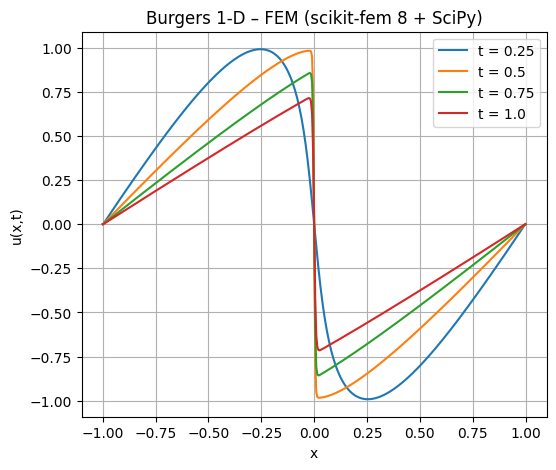

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse.linalg as spla
import skfem as sk
from skfem import BilinearForm, asm

# --------- 1. Malla y base P1
N_elem = 400
mesh   = sk.MeshLine(np.linspace(-1., 1., N_elem + 1))
basis  = sk.Basis(mesh, sk.ElementLineP1())

# --------- 2. Ensamblaje de matrices
@BilinearForm
def mass(u, v, w):
    return u * v

@BilinearForm
def stiffness(u, v, w):
    return u.grad[0] * v.grad[0]

@BilinearForm
def d_x(u, v, w):                 # ∫ u_x v dx   (para término convectivo)
    return u.grad[0] * v

M = asm(mass, basis).tocsc()
K = asm(stiffness, basis).tocsc()
D = asm(d_x, basis).tocsc()

# --------- 3. Condición inicial
x_nodes = basis.doflocs[0]
u0      = -np.sin(np.pi * x_nodes)           # incluye u(±1)=0 automáticamente

# --------- 4. DOFs de frontera (primer y último nodo)
bc_dofs = np.where(np.isclose(x_nodes, -1.) | np.isclose(x_nodes, 1.))[0]

# --------- 5. Parámetros y LU de M
nu   = 0.01 / np.pi
Minv = spla.factorized(M)                    # M⁻¹ aplicado como función

# RHS de la ODE semi-discreta  M ũ̇ = −diag(u) D u − ν K u
def rhs(_, u):
    ux     = D @ u
    conv   = u * ux
    visc   = nu * (K @ u)
    du     = -Minv(conv + visc)
    du[bc_dofs] = 0.0                       # fuerza du/dt=0 en la frontera
    return du

# --------- 6. Integración temporal (BDF implícito adaptativo)
from scipy.integrate import solve_ivp
sol = solve_ivp(rhs, (0.0, 1.0), u0,
                method='BDF', atol=1e-9, rtol=1e-6, dense_output=True)
print("solve_ivp:", sol.message)

# --------- 7. Post-proceso y comparación visual
times = [0.25, 0.5, 0.75, 1.0]
plt.figure(figsize=(6, 5))
for t in times:
    plt.plot(x_nodes, sol.sol(t).ravel(), label=f"t = {t}")
plt.xlabel("x"); plt.ylabel("u(x,t)")
plt.title("Burgers 1-D – FEM (scikit-fem 8 + SciPy)")
plt.legend(); plt.grid(); plt.show()


>Visualización 2D

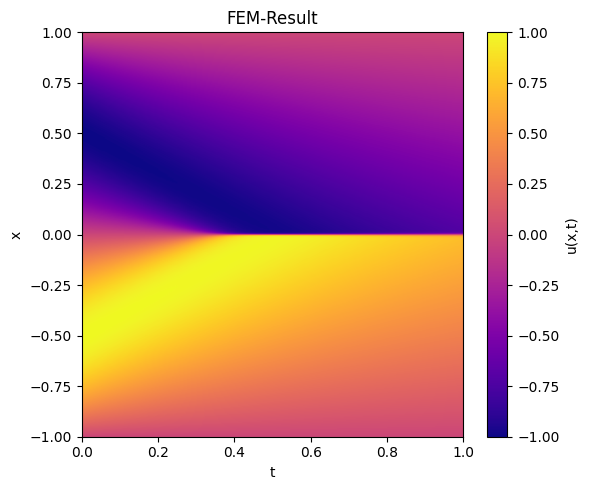

In [ ]:
# ------------------------------------------------------------
# Gráfico 2-D estilo “FEM-Result” (heat-map x–t)
# ------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt

# Malla temporal que quieras visualizar
n_t   = 200                             # resolución en tiempo
t_vec = np.linspace(0.0, 1.0, n_t)      # de 0 a 1

# Evalúa la solución FEM en todos esos tiempos
#   U_fem:  shape = (N_nodes, n_t)
U_fem = sol.sol(t_vec)                  # ¡sin reshape extra!

# Mapa de calor con la misma estética que el PINN
plt.figure(figsize=(6, 5))
im = plt.imshow(
    U_fem,                              # filas → x_nodes, columnas → t_vec
    extent=(0, 1, x_nodes[0], x_nodes[-1]),   # (t_min, t_max, x_min, x_max)
    origin='lower',                     # x = −1 abajo, x = +1 arriba
    aspect='auto',
    cmap='plasma'
)
plt.xlabel('t')
plt.ylabel('x')
plt.title('FEM-Result')
plt.colorbar(im, label='u(x,t)')
plt.tight_layout()
plt.savefig("ResultadoFEMExp3.pdf", format="pdf")
plt.show()


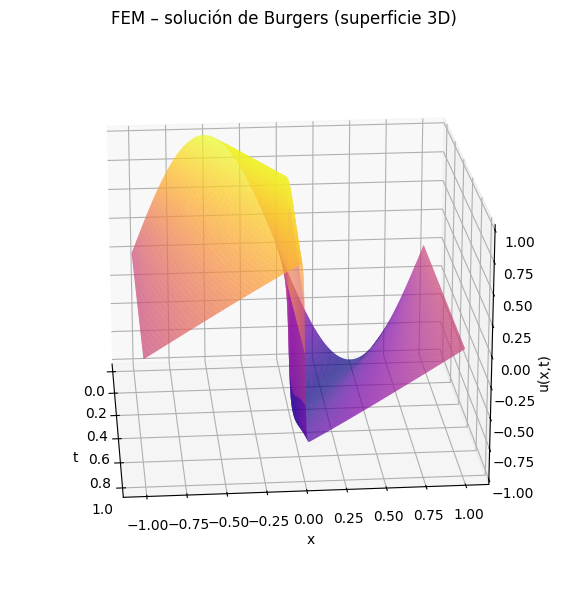

In [ ]:
# ------------------------------------------------------------
# Superficie 3-D de u(x,t) – FEM (scikit-fem + SciPy)
# ------------------------------------------------------------
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
import matplotlib.pyplot as plt
import numpy as np

# ── Si aún no existe U_fem y t_vec porque ejecutaste el notebook parcialmente:
# n_t   = 200
# t_vec = np.linspace(0.0, 1.0, n_t)
# U_fem = sol.sol(t_vec)   # shape: (N_nodes, n_t)

# Mallas 2-D coherentes con U_fem.T (dimensiones: n_t × N_nodes)
T_mesh, X_mesh = np.meshgrid(t_vec, x_nodes, indexing='ij')  # ambos (n_t, N_nodes)

fig = plt.figure(figsize=(8, 6))
ax  = fig.add_subplot(111, projection='3d')

# Decimado opcional para portátiles lentos
# skip = 4
# ax.plot_surface(T_mesh[::skip, ::skip],
#                 X_mesh[::skip, ::skip],
#                 U_fem.T[::skip, ::skip],
#                 cmap='plasma', edgecolor='none')

ax.plot_surface(T_mesh,             # eje X → tiempo
                X_mesh,             # eje Y → espacio
                U_fem.T,            # eje Z → u   (traspuesta para alinear)
                cmap='plasma',
                edgecolor='none',
                rstride=1, cstride=1, antialiased=True)

ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_zlabel('u(x,t)')
ax.set_title('FEM – solución de Burgers (superficie 3D)')
ax.view_init(elev=20, azim=-5)      # ajusta ángulos si lo deseas
plt.tight_layout()
plt.show()


> Gráfico 3D  Interactivo


In [ ]:
# ------------------------------------------------------------
# 3-D interactivo (Plotly) de u(x,t) – FEM
# ------------------------------------------------------------
# 1) Asegúrate de tener Plotly
!pip -q install plotly

import numpy as np
import plotly.graph_objs as go

# ── Si no existen todavía:
# n_t   = 200
# t_vec = np.linspace(0.0, 1.0, n_t)    # vector tiempos
# U_fem = sol.sol(t_vec)                # shape (N_nodes, n_t)

# 2) Mallado para la superficie
T_grid, X_grid = np.meshgrid(t_vec, x_nodes, indexing='ij')   # (n_t, N_nodes)

# 3) Construye la figura
fig = go.Figure(
    data=[
        go.Surface(
            z=U_fem.T,            # Z → u(x,t)  (traspuesta: n_t × N_nodes)
            x=T_grid,             # X → tiempo
            y=X_grid,             # Y → espacio
            colorscale="Plasma",
            showscale=True
        )
    ]
)

# 4) Etiquetas y formato
fig.update_layout(
    title="FEM – solución de Burgers (interactivo)",
    scene=dict(
        xaxis_title="t",
        yaxis_title="x",
        zaxis_title="u(x,t)"
    ),
    margin=dict(l=0, r=0, t=30, b=0)
)

fig.show()


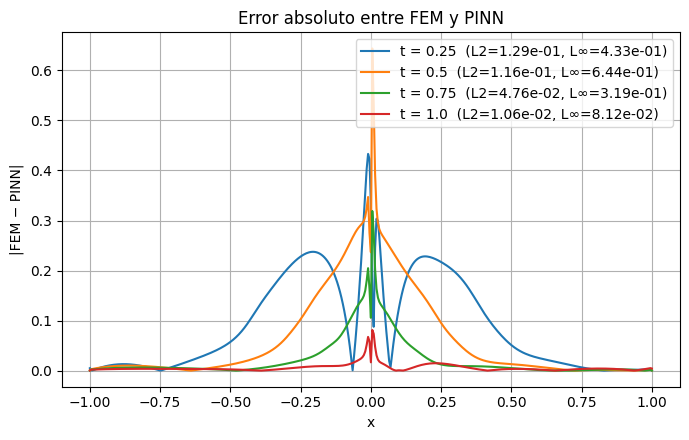


Normas del error (FEM vs PINN):
         t       L2-error        L∞-error
-------------------------------------------
  t = 0.25:   1.294617e-01   4.331794e-01
  t =  0.5:   1.159152e-01   6.439425e-01
  t = 0.75:   4.764950e-02   3.190755e-01
  t =  1.0:   1.063388e-02   8.124739e-02


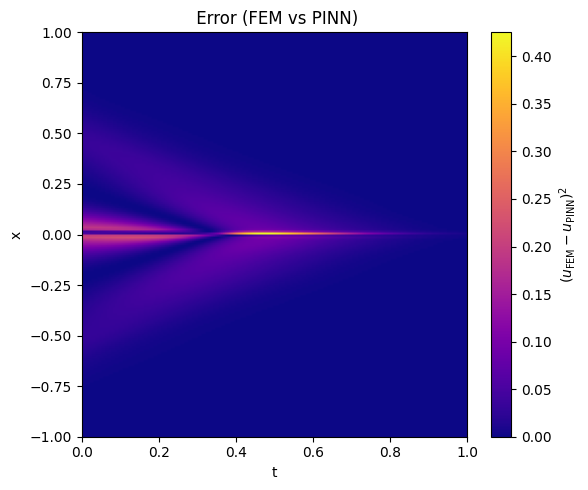

In [ ]:
# ============================================================
# COMPARACIÓN PINN vs FEM  ── errores L2, L∞, curvas y heat-map
# ============================================================

import torch, numpy as np, matplotlib.pyplot as plt

# ---------- 1. Datos de comparación -------------------------
times = [0.25, 0.5, 0.75, 1.0]          # mismos t que el usuario pidió
dx     = x_nodes[1] - x_nodes[0]        # espaciamiento de la malla FEM
domain_measure = x_nodes[-1] - x_nodes[0]  # |Ω_x| para normalizar L2

# Diccionarios para guardar soluciones y errores
fem_solutions  = {}
pinn_solutions = {}
l2_errors      = {}
linf_errors    = {}  # Nuevo diccionario para errores L∞

# Evalúa FEM (interpolación no necesaria: sol.sol(t) ya está en x_nodes)
for t in times:
    fem_solutions[t] = sol.sol(t).ravel()        # shape (N_nodes,)

# Evalúa PINN en los mismos x_nodes y tiempos
x_tensor = torch.tensor(x_nodes, dtype=torch.float32).reshape(-1, 1)
with torch.no_grad():
    for t in times:
        t_tensor = torch.full_like(x_tensor, t)
        pinn_pred = model(x_tensor, t_tensor).cpu().numpy().ravel()
        pinn_solutions[t] = pinn_pred

# ---------- 2. Curvas de error |FEM - PINN| -----------------
plt.figure(figsize=(7, 4.5))
for t in times:
    error = np.abs(fem_solutions[t] - pinn_solutions[t])

    # Cálculo de normas (con |Ω_x| = domain_measure para L2)
    l2_errors[t] = np.sqrt(np.sum(error**2) * dx / domain_measure)
    linf_errors[t] = np.max(error)  # Norma L∞

    plt.plot(x_nodes, error, label=f't = {t}  (L2={l2_errors[t]:.2e}, L∞={linf_errors[t]:.2e})')

plt.xlabel('x')
plt.ylabel('|FEM − PINN|')
plt.title('Error absoluto entre FEM y PINN')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------- 3. Imprime normas L2 y L∞ -----------------------
print('\nNormas del error (FEM vs PINN):')
print('         t       L2-error        L∞-error')
print('-------------------------------------------')
for t in times:
    print(f'  t = {t:>4}:   {l2_errors[t]:.6e}   {linf_errors[t]:.6e}')

# ---------- [Opcional] Heatmap del error --------------------
# (Manteniendo el código existente si lo tienes)

# ---------- 4. Heat-map 2-D del error cuadrático ------------
# Malla densa para la figura (200×200)
n_x, n_t = 200, 200
x_grid = np.linspace(-1., 1., n_x)
t_grid = np.linspace(0., 1., n_t)
Xg, Tg  = np.meshgrid(x_grid, t_grid, indexing='ij')

# Evalúa FEM y PINN en toda la malla
#  ▸ FEM: interpolamos con np.interp en cada fila de t_grid
#         (x_nodes es uniforme por construcción)
U_fem = np.empty_like(Xg)
for j, t in enumerate(t_grid):
    U_fem[:, j] = np.interp(x_grid, x_nodes, sol.sol(t).ravel())

#  ▸ PINN: forward en bloques para no agotar memoria
U_pinn = np.empty_like(Xg)
with torch.no_grad():
    for j, t in enumerate(t_grid):
        t_col = torch.full((n_x, 1), t)
        x_col = torch.tensor(x_grid, dtype=torch.float32).reshape(-1, 1)
        U_pinn[:, j] = model(x_col, t_col).cpu().numpy().ravel()

# Error cuadrático
E2 = (U_fem - U_pinn) ** 2

# ---------- 5. Gráfico estilo “Squared Error” ---------------
plt.figure(figsize=(6, 5))
im = plt.imshow(
    E2,
    extent=(0, 1, -1, 1),          # t horizontal, x vertical
    origin='lower',
    aspect='auto',
    cmap='plasma'
)
plt.xlabel('t')
plt.ylabel('x')
plt.title(' Error (FEM vs PINN)')
plt.colorbar(im, label=r'$(u_{\mathrm{FEM}} - u_{\mathrm{PINN}})^2$')
plt.tight_layout()
plt.savefig("ErrorFEMvsPINNEX3.pdf", format="pdf")
plt.show()
